# Project-2: Image Classification of Amazon Data

In this project, Image Classification was performed on meta data that contains large images from the **All Beauty**, **Digital Music**, and **Health and Personal Care** categories in the Amazon marketplace for the year 2023.

Firstly, the links to large images were extracted from the image features, and a new dataframe was created. The extensions of the images were analyzed, and thumbnails containing GIFs were removed. Numerous duplicate links were identified, and their copies were removed from the dataset. After cleaning the dataframe, `56991` samples were taken from each category to ensure class balance. Then, images were downloaded from the links and stored in folders corresponding to their categories. As the downloaded images had varying resolutions, all were resized to a resolution of `350 x 350`, and below the resolution of `224 x 224`  images resolution were removed. After image processing and cleaning, class imbalance occurred again, so a balanced dataset was created by resampling `40000` images from each category

Following these steps, to group products within each category or identify unwanted images, the embeddings of the images were extracted using the `ResNet50` model. The dimensions were reduced using `PCA`, and `K-Means` clustering was performed.

After completing the image preprocessing steps, one of the latest performant models, `EfficientNet`, was trained using the transfer learning method. The model was evaluated, and misclassified images were identified. Additionally, sample predictions were made on the test set.

The study was conducted on an AWS `g5.2xlarge` GPU-optimized spot instance. The data was uploaded to `AWS S3` and then fetched to the spot EC2 instance for processing.


# Data Specifications

| Category                  | #User   | #Item   | #Rating  | #R_Token | #M_Token |
|---------------------------|---------|---------|----------|----------|----------|
| All_Beauty               | 632.0K  | 112.6K  | 701.5K   | 31.6M    | 74.1M    |
| Digital_Music            | 101.0K  | 70.5K   | 130.4K   | 11.4M    | 22.3M    |
| Health_and_Personal_Care | 461.7K  | 60.3K   | 494.1K   | 23.9M    | 40.3M    |

[Data Source](https://amazon-reviews-2023.github.io/)

# Table of Contents

- [1. Data Loading and Validation](#1-data-loading-and-validation)
- [2. Data Preparation and Cleaning for Image Classification](#2-data-preparation-and-cleaning-for-image-classification)
  - [2.1. Parsing Images Feature](#21-parsing-images-feature)
  - [2.2. Removing Duplicate Images](#22-removing-duplicate-images)
  - [2.3. Filtering Images](#23-filtering-images)
  - [2.4. Sampling From Each Category](#24-sampling-from-each-category)
  - [2.5. Downloading Images From The Image Links](#25-downloading-images-from-the-image-links)
  - [2.6. Making Dataframe From Image Paths By Category](#26-making-dataframe-from-image-paths-by-category)
  - [2.7. Displaying Images From Each Category](#27-displaying-images-from-each-category)
  - [2.8. Displaying Images as Numpy Array](#28-displaying-images-as-numpy-array)
- [3. Exploratory Data Analysis](#3-exploratory-data-analysis)
  - [3.1. Analysis of Image Sizes and Channels](#31-analysis-of-image-sizes-and-channels)
  - [3.2. Visualization of the Image RGB Channels](#32-visualization-of-the-image-rgb-channels)
  - [3.3. Histogram of Each Category Images Pixel Distribution](#33-histogram-of-each-category-images-pixel-distribution)
- [4. Image Preprocessing](#4-image-preprocessing)
  - [4.1. Changing Resolution of the Images](#41-changing-resolution-of-the-images)
  - [4.2. Resampling From Cleaned and Processed Images](#42-resampling-from-cleaned-and-processed-images)
  - [4.3. Image Clustering](#43-image-clustering)
    - [4.3.1. Extracting Embeddings](#431-extracting-embeddings)
    - [4.3.2. Loading Embeddings and Clustering](#432-loading-embeddings-and-clustering)
- [5. Creating Image Classification Model](#5-creating-image-classification-model)
  - [5.1. Splitting the Image Dataset into Train, Validation, and Test Sets](#51-splitting-the-image-dataset-into-train-validation-and-test-sets)
  - [5.2. Creating EfficientNet Transfer Learning Model](#52-creating-efficientnet-transfer-learning-model)
  - [5.3. Model Evaluation](#53-model-evaluation)
    - [5.3.1. Analyzing Misclassifications](#531-analyzing-misclassifications)
    - [5.3.2. Prediction](#532-prediction)
- [6. Conclusion](#6-conclusion)


In [2]:
import os
from io import BytesIO
import random
import shutil
import glob
import logging
import asyncio
import aiohttp
from tqdm import tqdm
from itertools import compress
from typing import Optional, List, Tuple, Dict, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from PIL import Image
from PIL import UnidentifiedImageError
from scipy.cluster.vq import kmeans2
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.resnet import ResNet50,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.saving import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import  ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import saving

from warnings import filterwarnings
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', None)

plt.style.use("ggplot")
sns.set_palette(sns.diverging_palette(220, 20))
tqdm.pandas()

In [3]:
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TensorFlow version: 2.18.0
GPU is available


In [4]:
logging.basicConfig(
    level=logging.INFO, format= "%(asctime)s - %(levelname)s - %(message)s"
)

# 1. Data loading and Validation

The datasets containing Amazon images from three different categories have been downloaded from the source link, and the row counts have been verified. The `All Beauty` category contains `112590` records, the `Digital Music` category contains `70537` records, and the `Health and Personal Care` category contains `60293` records.

A missing value check was performed, and no missing data was found in `main_category` and `images` features.  

**Loading from local**

In [44]:
all_beauty_meta_file_path = "./data/all_beauty/meta_All_Beauty.jsonl.gz"
digital_music_meta_file_path = "./data/digital_music/meta_Digital_Music.jsonl.gz"
health_and_personal_care_meta_file_path = "./data/health_and_personal_care/meta_Health_and_Personal_Care.jsonl.gz"

all_beauty_meta_df = pd.read_json(all_beauty_meta_file_path, lines=True, compression="gzip")
digital_music_meta_df = pd.read_json(digital_music_meta_file_path, lines=True, compression="gzip")
health_and_personal_care_meta_df = pd.read_json(health_and_personal_care_meta_file_path, lines=True,compression="gzip")

all_beauty_meta_df["category"] = "all_beauty"
digital_music_meta_df["category"] = "digital_music"
health_and_personal_care_meta_df["category"] = "health_and_personal_care"

meta_names = ["all_beauty_meta_df", "digital_music_meta_df", "health_and_personal_care_meta_df"]
meta_dataframes = [all_beauty_meta_df, digital_music_meta_df, health_and_personal_care_meta_df]

print("# Shape check of each dataset:\n")
for name, df in zip(meta_names, meta_dataframes):
    print(f"Shape of the {name} dataset: {df.shape}")
    print(50 * "-")

print(50 * "*")
meta_data = pd.concat([all_beauty_meta_df, digital_music_meta_df, health_and_personal_care_meta_df], axis= 0)
meta_df = meta_data.copy()

print("The datasets from three different categories have been successfully concatenated into a single dataframe.")
print(f"Shape of the concatenated dataframe is {meta_df.shape}")
print(50 * "*")

# Shape check of each dataset:

Shape of the all_beauty_meta_df dataset: (112590, 15)
--------------------------------------------------
Shape of the digital_music_meta_df dataset: (70537, 15)
--------------------------------------------------
Shape of the health_and_personal_care_meta_df dataset: (60293, 15)
--------------------------------------------------
**************************************************
The datasets from three different categories have been successfully concatenated into a single dataframe.
Shape of the concatenated dataframe is (243420, 15)
**************************************************


**Loading from AWS S3**

In [8]:
s3_bucket_name = "kntbucket2"
s3_all_beauty_path = "data/all_beauty/All_Beauty.jsonl.gz"
s3_digital_music_path = "data/digital_music/Digital_Music.jsonl.gz"
s3_health_and_personal_care_path = "data/health_and_personal_care/Health_and_Personal_Care.jsonl.gz"

s3_client = boto3.client("s3",region_name="eu-central-1")

def read_s3_jsonl(bucket, key):
    response = s3_client.get_object(Bucket=bucket, Key=key)
    compressed_data = response["Body"].read()
    return pd.read_json(BytesIO(compressed_data), lines=True, compression="gzip")

s3_all_beauty_meta_path = "data/all_beauty/meta_All_Beauty.jsonl.gz"
s3_digital_music_meta_path = "data/digital_music/meta_Digital_Music.jsonl.gz"
s3_health_and_personal_care_meta_path = "data/health_and_personal_care/meta_Health_and_Personal_Care.jsonl.gz"

all_beauty_meta_df = read_s3_jsonl(s3_bucket_name, s3_all_beauty_meta_path)
digital_music_meta_df = read_s3_jsonl(s3_bucket_name, s3_digital_music_meta_path)
health_and_personal_care_meta_df = read_s3_jsonl(s3_bucket_name, s3_health_and_personal_care_meta_path)

all_beauty_meta_df["category"] = "all_beauty"
digital_music_meta_df["category"] = "digital_music"
health_and_personal_care_meta_df["category"] = "health_and_personal_care"


meta_names = ["all_beauty_meta_df", "digital_music_meta_df", "health_and_personal_care_meta_df"]
meta_dataframes = [all_beauty_meta_df, digital_music_meta_df, health_and_personal_care_meta_df]

print("# Shape check of each dataset:\n")
for name, df in zip(meta_names, meta_dataframes):
    print(f"Shape of the {name} dataset: {df.shape}")
    print(50 * "-")

print(50 * "*")
meta_data = pd.concat([all_beauty_meta_df, digital_music_meta_df, health_and_personal_care_meta_df], axis= 0)

meta_df = meta_data.copy()
print("The datasets from three different categories have been successfully concatenated into a single dataframe.")
print(f"Shape of the concatenated dataframe is {meta_df.shape}")
print(50 * "*")

# Shape check of each dataset:

Shape of the all_beauty_meta_df dataset: (112590, 15)
--------------------------------------------------
Shape of the digital_music_meta_df dataset: (70537, 15)
--------------------------------------------------
Shape of the health_and_personal_care_meta_df dataset: (60293, 15)
--------------------------------------------------
**************************************************
The datasets from three different categories have been successfully concatenated into a single dataframe.
Shape of the concatenated dataframe is (243420, 15)
**************************************************


In [9]:
meta_df = meta_data.copy()
meta_df = meta_df[["main_category","images"]]

In [10]:
meta_df.head(1)

main_category  \
0    All Beauty   

                                                                                                                                                                                                                                                                                                                                                                                                               images  
0  [{'thumb': 'https://m.media-amazon.com/images/I/41qfjSfqNyL._SS40_.jpg', 'large': 'https://m.media-amazon.com/images/I/41qfjSfqNyL.jpg', 'variant': 'MAIN', 'hi_res': None}, {'thumb': 'https://m.media-amazon.com/images/I/41w2yznfuZL._SS40_.jpg', 'large': 'https://m.media-amazon.com/images/I/41w2yznfuZL.jpg', 'variant': 'PT01', 'hi_res': 'https://m.media-amazon.com/images/I/71i77AuI9xL._SL1500_.jpg'}]

**There is no any missing values in the main_category and images**

In [11]:
meta_df.isnull().sum()

main_category    0
images           0
dtype: int64

**Count of images in each category**

In [12]:
meta_df["main_category"].value_counts().reset_index()

main_category   count
0              All Beauty  112135
1           Digital Music   70537
2  Health & Personal Care   60293
3          Premium Beauty     455

Because of Premium Beauty category has fewer values and also it belongs to All Beauty category, it has been evaluated in All Beauty category

In [13]:
meta_df["main_category"] = meta_df["main_category"].replace("Premium Beauty", "All Beauty")
meta_df["main_category"].value_counts().reset_index()

main_category   count
0              All Beauty  112590
1           Digital Music   70537
2  Health & Personal Care   60293

# 2. Data Preparation and Cleaning for Image Classification

## 2.1 Parsing Images Feature

The images feature in the dataset is a list of dictionaries, each containing the URL of different size of images. The large images that will be used for classification have been parsed from images feaure.

The lambda function checks if the input x is a list, contains at least one element, and if the first element of the list has the key "large", returning the corresponding "large" value; otherwise, it returns nan value.

In [14]:
meta_df.head(1)

main_category  \
0    All Beauty   

                                                                                                                                                                                                                                                                                                                                                                                                               images  
0  [{'thumb': 'https://m.media-amazon.com/images/I/41qfjSfqNyL._SS40_.jpg', 'large': 'https://m.media-amazon.com/images/I/41qfjSfqNyL.jpg', 'variant': 'MAIN', 'hi_res': None}, {'thumb': 'https://m.media-amazon.com/images/I/41w2yznfuZL._SS40_.jpg', 'large': 'https://m.media-amazon.com/images/I/41w2yznfuZL.jpg', 'variant': 'PT01', 'hi_res': 'https://m.media-amazon.com/images/I/71i77AuI9xL._SL1500_.jpg'}]

In [15]:
meta_df["images"] = meta_df["images"].progress_apply(lambda x: x[0]["large"] if isinstance(x, list) and len(x) > 0 and "large" in x[0] else np.nan)

100%|██████████████████████████████████████████████████████████████████████████| 243420/243420 [00:00<00:00, 920628.93it/s]


In [16]:
meta_df.head()

main_category                                               images
0    All Beauty  https://m.media-amazon.com/images/I/41qfjSfqNyL.jpg
1    All Beauty  https://m.media-amazon.com/images/I/41b+11d5igL.jpg
2    All Beauty  https://m.media-amazon.com/images/I/31bz+uqzWCL.jpg
3    All Beauty  https://m.media-amazon.com/images/I/515iwxdKS1L.jpg
4    All Beauty  https://m.media-amazon.com/images/I/31TgqAZ8kQL.jpg

In [17]:
meta_df.isnull().sum()

main_category    0
images           1
dtype: int64

In [18]:
meta_df.dropna(axis=0, inplace=True)

In [19]:
meta_df["main_category"].value_counts().reset_index()

main_category   count
0              All Beauty  112590
1           Digital Music   70536
2  Health & Personal Care   60293

## 2.2. Removing duplicate Images

The dataset has been checked for duplicate image links, and it was found that `13177` links are identical. One instance of each duplicate will be removed from the dataset. Additionally, it was observed that some `thumbnail GIFs` have been included in the data, and these will be filtered out in the next stage.

In [20]:
meta_df[meta_df["images"].duplicated(keep="first")].shape

(13177, 2)

In [21]:
meta_df[meta_df["images"].duplicated(keep="first")].head()

main_category                                               images
802     All Beauty  https://m.media-amazon.com/images/I/41C6ZNQH3HL.jpg
1158    All Beauty  https://m.media-amazon.com/images/I/01RmK+J4pJL.gif
1978    All Beauty  https://m.media-amazon.com/images/I/01RmK+J4pJL.gif
2287    All Beauty  https://m.media-amazon.com/images/I/01RmK+J4pJL.gif
2290    All Beauty  https://m.media-amazon.com/images/I/01RmK+J4pJL.gif

In [22]:
meta_df = meta_df.drop_duplicates(subset=["images"], keep="first")
meta_df[meta_df["images"].duplicated(keep="first")].shape

(0, 2)

## 2.3. Filtering Images

This section will include images with the extensions '.jpg', '.jpeg', '.png', and '.webp', while GIFs will be excluded.

In [23]:
def filter_images(link: str) -> str:
    """
    Checks if a single image link has a valid image extension and returns the link
    if valid, otherwise returns NaN.
    
    Parameters
    ----------
    file : str
        A single file path to check.
    
    Returns
    -------
    str
        The file path if it's a valid image file, otherwise NaN.
    """
    valid_extensions = {".jpg", ".jpeg", ".png", ".webp"}
    return link if any(link.endswith(ext) for ext in valid_extensions) else np.nan

In [24]:
meta_df["images"] = meta_df["images"].progress_apply(filter_images)

100%|██████████████████████████████████████████████████████████████████████████| 230242/230242 [00:00<00:00, 594281.43it/s]


In [25]:
meta_df.isnull().sum()

main_category     0
images           70
dtype: int64

In [26]:
meta_df.dropna(axis=0, inplace=True)

**Extension check**

Ensured that all images are in `jpg` format.

In [27]:
meta_df["extension"] = meta_df["images"].progress_apply(lambda x: x.split('.')[-1])

100%|█████████████████████████████████████████████████████████████████████████| 230172/230172 [00:00<00:00, 1276047.16it/s]


100%|██████████| 230172/230172 [00:00<00:00, 845465.93it/s]


In [28]:
meta_df["extension"].value_counts()

extension
jpg    230172
Name: count, dtype: int64

## 2.4. Sampling From Each Category

The dataset will be sampled from each category to ensure a balanced representation for training the model. This will help prevent any bias or imbalance in the dataset, which could impact the model's performance.
For this purpose, `56991` sample images will be taken from the categories All Beauty, Digital Music, and Health and Personal Care, which is the minimum number of Health and Personal Care category.

In [29]:
meta_df["main_category"].value_counts().reset_index()

main_category   count
0              All Beauty  106875
1           Digital Music   66306
2  Health & Personal Care   56991

In [30]:
meta_df = meta_df.groupby("main_category").sample(n=56991, replace=False, random_state=42)
meta_df["main_category"].value_counts().reset_index()

main_category  count
0              All Beauty  56991
1           Digital Music  56991
2  Health & Personal Care  56991

## 2.5. Downloading Images From The Image Links

**Processing Time and Performance Improvement:**

Initially, downloading images using the **`requests`** library took a long time. To speed up the process, **asynchronous programming** was implemented, and tasks were parallelized. **`asyncio`** and **`aiohttp`** libraries were used to parallelize the tasks. Since **`requests`** is a synchronous library, the process was waiting for each image to be downloaded before proceeding to the next one. This caused significant time loss with large datasets. **By using asynchronous structures**, this issue was addressed, and **the tasks were performed in parallel.**

Also, User-Agent and Accept headers are added to indicate that the request is coming from a browser. This ensures that the server responds correctly, as some servers may only accept requests from browsers and reject programmatic requests.

**`asyncio`** is a library in Python used for asynchronous programming. **Asynchronous programming** allows multiple tasks to be started at the same time, without waiting for each to finish before moving on to the next one. This way, time-consuming tasks (such as downloading data over the network) can be executed concurrently. **With this approach**, the processing time was reduced.

**Measures Taken to Prevent Overloading the Server:**

- **Concurrency Limit:** The number of simultaneous requests was limited. **`asyncio.Semaphore`** was used to restrict the number of concurrent requests to `50`, preventing the server from being overloaded.
  
- **Random Wait Time:** After each image download, a random wait time between `0.2 and 0.5` seconds was added to avoid **overloading the server**. **As a result**, even though requests were sent at high speed, the server’s response time remained at normal levels.

With these adjustments, the image download time was significantly accelerated. **Asynchronous structures were used** and **task limits were applied**, allowing tasks to be processed in parallel, significantly reducing the overall processing time.


In [31]:
async def create_directory(dir_path: str) -> None:
    """
    Creates a directory if it does not already exist.

    Parameters
    ----------
    dir_path : str
        Path of the directory to be created.

    Returns
    -------
    None
    """
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        logging.info(f"Directory created: {dir_path}")
    else:
        logging.warning(f"Directory already exists: {dir_path}")

async def download_image(url, save_path, session, semaphore):
    """
    Asynchronously downloads an image and saves it to the specified path.

    Parameters
    ----------
    url : str
        URL of the image to download.
    save_path : str
        Path where the image will be saved.
    session : aiohttp.ClientSession
        The session to use for downloading the image.
    semaphore : asyncio.Semaphore
        Semaphore to limit the number of concurrent downloads.

    Returns
    -------
    None
    """
    async with semaphore:
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
            "Accept": "image/*"
        }
        try:
            # sleep between 0.2 and 0.5 seconds to avoid overloading the server
            await asyncio.sleep(random.uniform(0.2, 0.5))  
            
            async with session.get(url, headers=headers, timeout=10) as response:
                response.raise_for_status()  
                with open(save_path, 'wb') as f:
                    f.write(await response.read())  
        except Exception as e:
            logging.error(f"Failed to download {url}: {e}")

async def save_images_by_category(df, image_column, category_column, base_dir="./data/images"):
    """
    Saves images to directories based on their categories.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing image URLs and categories.
    image_column : str
        Name of the column with image URLs.
    category_column : str
        Name of the column with categories.
    base_dir : str, optional
        Base directory where images will be saved (default is "images").

    Returns
    -------
    None
    """
    logging.info(f"Images are downloading....")

    # Limit the number of concurrent downloads. Max 50
    semaphore = asyncio.Semaphore(50)

    create_directory(base_dir)
    async with aiohttp.ClientSession() as session:
        tasks = []

        for category in df[category_column].unique():
            formatted_category = category.lower().replace(" ", "_").replace("&", "and")
            category_dir = os.path.join(base_dir, formatted_category)
            await create_directory(category_dir)  
            
            category_df = df[df[category_column] == category]
            for _, row in category_df.iterrows():
                image_url = row[image_column]
                image_name = os.path.basename(image_url)
                save_path = os.path.join(category_dir, image_name)
                tasks.append(download_image(image_url, save_path, session, semaphore))

        await asyncio.gather(*tasks)

    logging.info(f"Images have downloaded and saved successfully.")


In [32]:
await save_images_by_category(meta_df, image_column="images", category_column="main_category")

2024-12-22 13:41:46,240 - INFO - Images are downloading....
2024-12-22 13:41:46,291 - INFO - Directory created: ./data/images/all_beauty
2024-12-22 13:41:49,245 - INFO - Directory created: ./data/images/digital_music
2024-12-22 13:41:51,228 - INFO - Directory created: ./data/images/health_and_personal_care
2024-12-22 13:42:55,786 - ERROR - Failed to download https://m.media-amazon.com/images/I/41a2mLrUvGL.jpg: 404, message='Not Found', url='https://m.media-amazon.com/images/I/41a2mLrUvGL.jpg'
2024-12-22 13:49:37,411 - ERROR - Failed to download https://m.media-amazon.com/images/I/51WPQ4N1XFL.jpg: 404, message='Not Found', url='https://m.media-amazon.com/images/I/51WPQ4N1XFL.jpg'
2024-12-22 13:50:32,584 - ERROR - Failed to download https://m.media-amazon.com/images/I/210UJTrFLAL.jpg: 404, message='Not Found', url='https://m.media-amazon.com/images/I/210UJTrFLAL.jpg'
2024-12-22 13:50:39,741 - ERROR - Failed to download https://m.media-amazon.com/images/I/21aBUgZxXuL.jpg: 404, message='No

## 2.6. Making Dataframe From Image Paths By Category

The dataframe has been created from the image paths to help with processing operations in the further stages.

In [17]:
def df_from_image_folders(images_path: str, extension: Optional[str] = "jpg") -> pd.DataFrame:
    """
    Create a DataFrame from image files in specified directories.

    Parameters
    ----------
    images_path : str
        Path to the directory containing subdirectories of images.
    extension : str, optional
        The file extension of the images to include (default is "jpg").

    Returns
    -------
    pd.DataFrame
        A DataFrame with two columns: 'category' and 'path'.

    """
    
    category = []
    path = []
    image_files = glob.glob(os.path.join(images_path, "**", f"*.{extension.lower()}"), recursive=True)

    for file in image_files:
        dirpath = os.path.dirname(file)
        folder_name = os.path.basename(dirpath)
        category.append(folder_name)
        path.append(file)

    class_dict = {"category": category, "path": path,}
    
    logging.info("Dataframe has been successfully created.")
    
    return pd.DataFrame(class_dict)

In [9]:
image_directory = "./data/images"
df = df_from_image_folders(image_directory)
df.head()

2024-12-22 14:37:13,027 - INFO - Dataframe has been successfully created.


category  \
0  health_and_personal_care   
1  health_and_personal_care   
2  health_and_personal_care   
3  health_and_personal_care   
4  health_and_personal_care   

                                                          path  
0  ./data/images/health_and_personal_care/31a7DtUkj9L._AC_.jpg  
1  ./data/images/health_and_personal_care/41oPxyvfErL._AC_.jpg  
2  ./data/images/health_and_personal_care/51lX5FLmgnL._AC_.jpg  
3  ./data/images/health_and_personal_care/51fes60cNKL._AC_.jpg  
4  ./data/images/health_and_personal_care/31GUcGavxxL._AC_.jpg

In [10]:
df["category"].value_counts().reset_index()

category  count
0             digital_music  56570
1                all_beauty  52733
2  health_and_personal_care  40080

## 2.7. Displaying Images From Each Category

In [19]:
def display_images_by_category(df: pd.DataFrame, category_name: str, num_images: int, img_size: Tuple[int, int] = (224, 224)) -> None:
    """
    Displays a specified number of images from a given category in the DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing image paths and categories.
    class_name : str
        The category to filter the images.
    img_size : Tuple[int, int]
        Size to which images will be resized for display.
    num_images : int
        Number of images to display from the given class.
    """
    images = df[df["category"] == category_name]["path"].iloc[-num_images:]
    plt.figure(figsize=(12, 12))

    for i, image_path in enumerate(images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(load_img(image_path, target_size=img_size))
        plt.title(image_path[-5:-4]) 
        plt.axis('off')

    plt.show()

Category name: health_and_personal_care


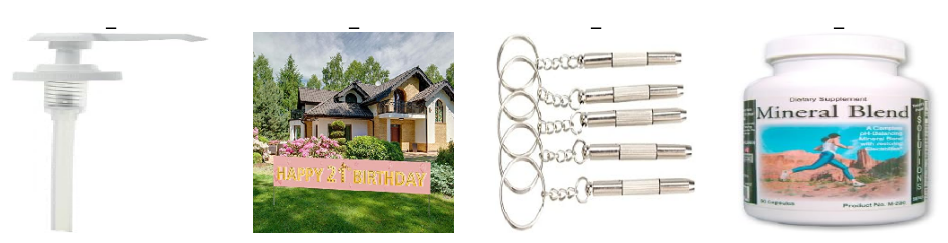

Category name: all_beauty


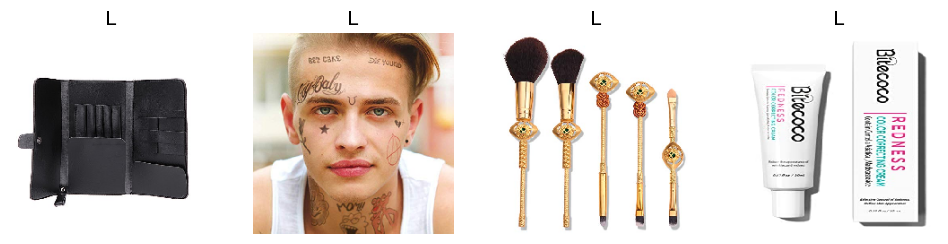

Category name: digital_music


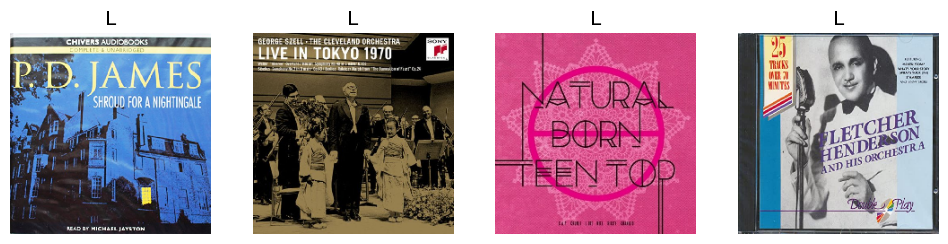

In [41]:
for category in df["category"].unique():
    print(f"Category name: {category}")
    display_images_by_category(df, category, 4)

## 2.8. Displaying Images as Numpy Array

In [42]:
def display_image_as_array(image_path: str) -> None:
    """
    Displays an image as a NumPy array.

    Parameters
    ----------
    image_path : str
        Path to the image file.

    Returns
    -------
    None
    """
    image = Image.open(image_path)
    image_array = np.array(image)
    print("Image as NumPy array:")
    print(image_array)

In [43]:
image_path = df["path"][0] 
display_image_as_array(image_path)

Image as NumPy array:
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


# 3. Exploratory Data Analysis

## 3.1. Analysis of Image Sizes and Channels

The purpose of this study is to standardize images if they are different sizes.

In [6]:
def compute_image_statistics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Computes average width, height, and channel count for images listed in the DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'path' and 'category' columns for images.

    Returns:
        pd.DataFrame: DataFrame containing average statistics for each category.
    """
    stats = []

    grouped = df.groupby("category")

    for category, group in tqdm(grouped, desc="computing..."):
        widths = []
        heights = []
        channel_counts = []

        for _, row in group.iterrows():
            image_path = row["path"]
            try:
                image = load_img(image_path)
                image_array = img_to_array(image)
                
                width, height = image.size
                widths.append(width)
                heights.append(height)
                channel_counts.append(image_array.shape[2])
            except UnidentifiedImageError as e:
                logging.warning(f"Unidentified image error for {image_path}: {e}")
            except Exception as e:
                logging.warning(f"Error loading image {image_path}: {e}")
        
        if widths:  
            avg_width = np.mean(widths)
            avg_height = np.mean(heights)
            avg_channels = np.mean(channel_counts)
            min_width = np.min(widths)
            max_width = np.max(widths)
            min_height = np.min(heights)
            max_height = np.max(heights)

            stats.append({
                'Category': category,
                'Average Width': avg_width,
                'Average Height': avg_height,
                'Average Channels': avg_channels,
                'Min Width': min_width,
                'Max Width': max_width,
                'Min Height': min_height,
                'Max Height': max_height  
            })
            
    return pd.DataFrame(stats)

In [104]:
df_statistics = compute_image_statistics(df)
df_statistics

computing...: 100%|██████████| 3/3 [04:16<00:00, 85.39s/it]


Category  Average Width  Average Height  Average Channels  \
0                all_beauty         466.57          478.97              3.00   
1             digital_music         440.58          424.65              3.00   
2  health_and_personal_care         384.31          412.82              3.00   

   Min Width  Max Width  Min Height  Max Height  
0         28        960          29         960  
1         47        991          58         984  
2         32        800          36         980

## 3.2. Visualization of the image rgb channels

In [105]:
def display_rgb_channels(image_path: str) -> None:
    """
    Displays the individual RGB channels of an image.

    Parameters
    ----------
    image_path : str
        The file path to the image.

    Returns
    -------
    None
    """
    image = Image.open(image_path)
    
    r, g, b = image.split()
    
    r_array = np.array(r)
    g_array = np.array(g)
    b_array = np.array(b)

    fig, axes = plt.subplots(1, 3, figsize=(10,4))

    axes[0].imshow(r_array, cmap="Reds")
    axes[0].set_title("Red Channel")
    axes[0].axis("off")

    axes[1].imshow(g_array, cmap="Greens")
    axes[1].set_title("Green Channel")
    axes[1].axis("off")

    axes[2].imshow(b_array, cmap="Blues")
    axes[2].set_title("Blue Channel")
    axes[2].axis("off")

    plt.show()

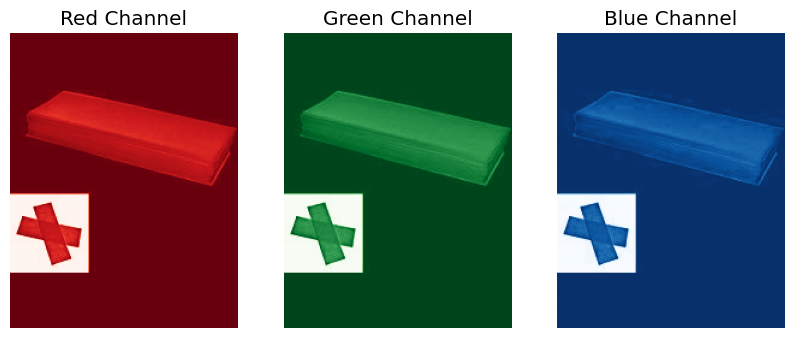

In [106]:
sample_image = df["path"][10]
display_rgb_channels(sample_image)

## 3.3. Histogram of the each category images pixel distribution

This time, the load_img function from Keras is used for image visualization, and the histogram of pixel distributions for each category has been plotted.

In [107]:
def plot_average_pixel_distribution(df: pd.DataFrame, target_size: tuple = (224, 224)) -> None:
    """
    Plots average pixel value distribution for each category.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'path' and 'category' columns.
    target_size (tuple): Size to which each image will be resized (default is (224, 224)).

    Returns:
    None: Displays the average pixel value histograms for each class.
    """
    unique_labels = df["category"].unique()
    plt.figure(figsize=(15, 10))
 
    for i, category in enumerate(unique_labels):
       
        class_images = df[df["category"] == category]["path"].values
        images = []
      
        for image_path in class_images:
            image = load_img(image_path, target_size=target_size)
            images.append(image)
        
        images = np.array(images)
        avg_pixel_values = np.mean(images, axis=(0, 1, 2))  
       
        plt.subplot(3, 3, i + 1) 
        plt.hist(avg_pixel_values, bins=50, range=(0, 255), color='blue', alpha=0.7)
        plt.title(f'{category} Pixel Value Distribution')
        plt.xlabel('Pixel Value (0-255)')
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

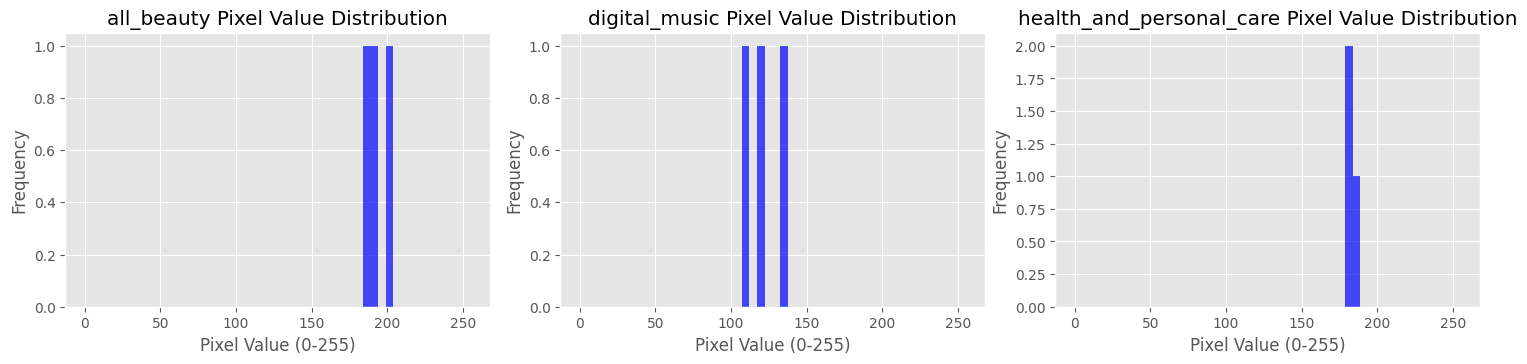

In [108]:
plot_average_pixel_distribution(df)

# 4. Image Preprocessing

In this section many preprocessing steps have been carried out to filter these images in the best possible way. Changing resolution, embedding, clustering, splitting, normalization, and data augmentation processes have been applied.

## 4.1. Changing resolution of the images


When examining the statistics of images scraped from the internet, the average width and height are approximately 400 pixels. However, some images may have very small dimensions. Therefore, it is essential to standardize the image sizes. In this project, images will be resized to 350 x 350 pixels, and images smaller than 224 x 224 will be removed from the dataset.

The reason for performing this operation is that the images in our dataset might have varying resolutions, such as 4992 x 3328 or 1280 x 1224. Additionally, there might be very small images, for instance, 50 x 50. By resizing the resolution, the sizes of the images in our dataset are standardized. Moreover, it is ensured that small images, which could negatively impact the model's performance, are removed from the dataset. For example, if the images are standardized to 800 x 600, the input size for the model can later be adjusted as needed, such as 224 x 224 or 512 x 512.

To address this, max and min resolution filter functions were written.

**The images are resized without distortion using the following formula:**

- **Original width:** 1200 pixels  
- **Original height:** 800 pixels  
- **Target width:** 350 pixels  
- **Target height:** 350 pixels  

The scaling ratios are calculated as follows:

- **Width ratio:** 350 / 1200 ≈ 0.2916  
- **Height ratio:** 350 / 800 = 0.4375  

This ratio is used to scale both dimensions of the image to fit within the target size:

- **New width:** 1200 * 0.3333 ≈ 350 pixels  
- **New height:** 800 * 0.5 ≈ 350 pixels  


In [7]:
def max_resolution_rescale_and_delete(df: pd.DataFrame, image_column: str, max_width: int, max_height: int, min_width: int, min_height: int):
    """
    Resizes images to fit within the specified maximum width and height,
    saves the resized image back with the same filename, and deletes images 
    smaller than the specified minimum dimensions from both the disk and the DataFrame.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing image file paths.
    image_column : str
        Name of the column that contains the image paths.
    max_width : int
        The maximum width to resize the images.
    max_height : int
        The maximum height to resize the images.
    min_width : int
        The minimum width for images to be kept.
    min_height : int
        The minimum height for images to be kept.
    
    Returns
    -------
    pandas.DataFrame
        Updated DataFrame with small images removed.
    """
    rows_to_remove = []

    for idx, row in tqdm(df.iterrows(), desc="Processing images", total=df.shape[0]):
        image_path = row[image_column]
        
        if not os.path.exists(image_path):
            logging.warning(f"Image does not exist: {image_path}")
            continue
        
        try:
            image = Image.open(image_path)
        except Exception as e:
            logging.error(f"Failed to open image {image_path}: {e}")
            continue
        
        width, height = image.size
    
        width_ratio = max_width / width
        height_ratio = max_height / height
        
        ratio = min(width_ratio, height_ratio)
    
        new_width = int(width * ratio)
        new_height = int(height * ratio)
        
        image_resized = image.resize((new_width, new_height), Image.LANCZOS)
        
        image_resized.save(image_path)

        if new_width < min_width or new_height < min_height:
            os.remove(image_path)  
            rows_to_remove.append(idx)  

    df = df.drop(rows_to_remove).reset_index(drop=True)
    logging.info(f"Removed {len(rows_to_remove)} images.")

    return df

In [11]:
df = max_resolution_rescale_and_delete(df,"path", 350, 350, 224, 224)
df.head()

Processing images: 100%|██████████████████████████████████████████████████████████| 149383/149383 [05:53<00:00, 422.28it/s]
2024-12-22 14:43:36,306 - INFO - Removed 750 images.


category  \
0  health_and_personal_care   
1  health_and_personal_care   
2  health_and_personal_care   
3  health_and_personal_care   
4  health_and_personal_care   

                                                          path  
0  ./data/images/health_and_personal_care/31a7DtUkj9L._AC_.jpg  
1  ./data/images/health_and_personal_care/41oPxyvfErL._AC_.jpg  
2  ./data/images/health_and_personal_care/51lX5FLmgnL._AC_.jpg  
3  ./data/images/health_and_personal_care/51fes60cNKL._AC_.jpg  
4  ./data/images/health_and_personal_care/31GUcGavxxL._AC_.jpg

In [12]:
compute_image_statistics(df)

computing...: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [01:49<00:00, 36.38s/it]


Category  Average Width  Average Height  Average Channels  \
0                all_beauty         341.18          343.52              3.00   
1             digital_music         344.73          332.95              3.00   
2  health_and_personal_care         324.90          327.17              3.00   

   Min Width  Max Width  Min Height  Max Height  
0        224        350         224         350  
1        224        350         224         350  
2        224        350         224         350

In [13]:
image_directory = "./data/images"
df = df_from_image_folders(image_directory)
df["category"].value_counts()

2024-12-22 14:45:34,347 - INFO - Dataframe has been successfully created.


category
digital_music               55820
all_beauty                  52733
health_and_personal_care    40080
Name: count, dtype: int64

## 4.2. Resampling From Cleaned and Processed Images

After the data was cleaned and processed, class imbalance reoccurred, so a balanced dataset was prepared for each category by resampling from these cleaned and standardized images.

In [14]:
def sample_and_copy_images(df: pd.DataFrame, category: str, image_col: str, save_path: str, sample_size: int) -> None:
    """
    Samples images from a dataframe by category and copies them to a new directory structure.

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe containing image paths and categories.
    category : str
        The column name in the dataframe that contains the category column.
    image_col : str
        The column name in the dataframe that contains the file paths of the images.
    save_path : str
        The root directory where the sampled images will be saved. Each category will be stored
        in a subdirectory named after the category.
    sample_size : int
        The number of samples to select for each category. If the number of available images
        in a category is less than the sample size, no sampling will occur for that category.

    """

    os.makedirs(save_path, exist_ok=True)
    grouped = df.groupby(category)

    for category, group in tqdm(grouped, desc="Sampling images by category"):
        if len(group) < sample_size:
            print(f"Skipping category {category} as it has fewer images than the sample size.")
            continue

        # Sample images
        sampled = group.sample(n=sample_size, replace=False, random_state=42)
        category_path = os.path.join(save_path, category)
        os.makedirs(category_path, exist_ok=True)

        # Copy the sampled images to the new directory
        for _, row in sampled.iterrows():
            src_path = row[image_col]
            dst_path = os.path.join(category_path, os.path.basename(src_path))
            shutil.copy(src_path, dst_path)

In [15]:
destination_path = "./data/resampled_images"
sample_and_copy_images(df,"category", "path", destination_path, 40000)

Sampling images by category: 100%|███████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.71s/it]


**Creating new Dataframe from resampled images**

In [16]:
image_directory = "./data/resampled_images"
df = df_from_image_folders(image_directory)
df["category"].value_counts()

2024-12-22 14:46:59,997 - INFO - Dataframe has been successfully created.


category
health_and_personal_care    40000
all_beauty                  40000
digital_music               40000
Name: count, dtype: int64

In [17]:
df.head()

category  \
0  health_and_personal_care   
1  health_and_personal_care   
2  health_and_personal_care   
3  health_and_personal_care   
4  health_and_personal_care   

                                                                    path  
0  ./data/resampled_images/health_and_personal_care/31a7DtUkj9L._AC_.jpg  
1  ./data/resampled_images/health_and_personal_care/41oPxyvfErL._AC_.jpg  
2  ./data/resampled_images/health_and_personal_care/51lX5FLmgnL._AC_.jpg  
3  ./data/resampled_images/health_and_personal_care/51fes60cNKL._AC_.jpg  
4  ./data/resampled_images/health_and_personal_care/31GUcGavxxL._AC_.jpg

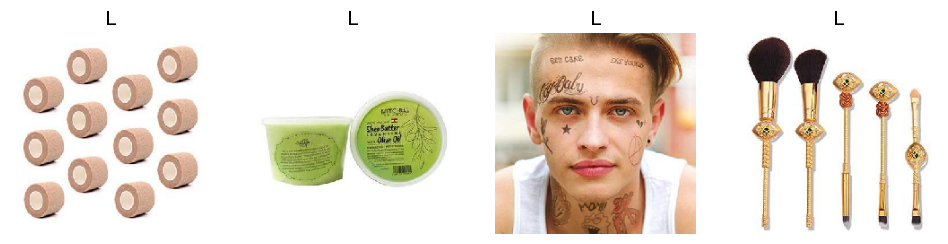

In [20]:
display_images_by_category(df, "all_beauty", 4)

## 4.3. Image Clustering

Unwanted images that are not suitable for the model may be mixed in the data. Since we cannot manually check and separate a large number of images one by one, we can classify the images using unsupervised learning techniques to more easily remove these images from the dataset.
Additionally, we might want to group images belonging to a specific category. For this purpose, clustering can be useful.

To do this, we first need to extract the embeddings of the images. The `ResNet50` model has been used for embedding extraction which is popular for embedding jobs. The final softmax layer of the `ResNet50` model has been removd, and the embeddings from the fully connected layer with `2048` units have been obtained. That s, the values of `Z = WA + b`, which pass through the activation function. Since the size of the embeddings vectors is 2048, it is necessary to reduce the dimensions of these vectors. The more we reduce the dimensions, the more suitable the data becomes for clustering.

PCA has been used for the dimensionality reduction process. It is necessary to perform standardization before `PCA` and `K-means`. However, since our data already came from `ResNet50` in a certain standard, no additional standardization has been performUsing these techniques, the embedding dimensions have been reduced to 16, and each ctegory has been divided into 4 separate clustersed.

The clustering process has been successful. The images have been classified according to the direction of the photo capture. However, the classification revealed that all images are suitable for model training, with no unsuitable images detected.


In [148]:
def load_image(image_path: str) -> Image.Image:
    """
    Load an image in RGB format from the given path.

    Parameters
    ----------
    image_path : str
        Path to the image file.

    Returns
    -------
    Image.Image
        Loaded image.
    """
    image = Image.open(image_path).convert("RGB")
    return image


class Img2VecKeras:
    def __init__(self):
        """
        Initialize the Img2VecKeras class with the ResNet50 model for embedding extraction.
        """
        base_model = ResNet50(weights="imagenet")
        self.model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
    
    def get_vec(self, img_paths: List[str]) -> np.ndarray:
        """
        Extract embeddings for the given list of image paths.

        Parameters
        ----------
        img_paths : List[str]
            A list of paths to the images for which embeddings are to be extracted.
        
        Returns
        -------
        np.ndarray
            An array of shape (n_samples, n_features) containing the embeddings.
        """
        embeddings = []
        for img_path in img_paths:
            img = load_image(img_path) 
            img = img.resize((224, 224)) 
            img = image.img_to_array(img)  
            img = np.expand_dims(img, axis=0)  
            img = preprocess_input(img)  
            embedding = self.model.predict(img, verbose=0)  
            embeddings.append(embedding.flatten()) 
        return np.array(embeddings)

def extract_and_save_embeddings(df: pd.DataFrame, embedding_path: str) -> None:
    """
    Extract embeddings from images using a DataFrame and save them to CSV files.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing image paths and their respective labels.
    embedding_path : str
        The directory where the extracted embeddings will be saved as CSV files.
    
    Returns
    -------
    None
    """
   
    if not os.path.exists(embedding_path):
        os.makedirs(embedding_path)

    grouped = df.groupby("category")

    for label, group in tqdm(grouped, desc="Extracting Embeddings", unit="image"):
        img_paths = group["path"].tolist()  
        
        img2vec_keras = Img2VecKeras()
        embeddings = img2vec_keras.get_vec(img_paths)

        df_embeddings = pd.DataFrame(embeddings)
        df_embeddings["filepaths"] = img_paths
        
        output_file = os.path.join(embedding_path, f"{label}_embeddings.csv")
        df_embeddings.to_csv(output_file, index=False)
        
    print(f"Saved embeddings for to {embedding_path}")

### 4.3.1 Extracting Embeddings

In [149]:
embedding_path = "./data/images_embeddings"
extract_and_save_embeddings(df, embedding_path)

Extracting Embeddings: 100%|██████████| 3/3 [1:02:53<00:00, 1257.73s/image]

Saved embeddings for to ./data/images_embeddings


### 4.3.2 Loading Embeddings and Clustering

In [152]:
def load_embeddings_from_directory(directory: str) -> List[Tuple[np.ndarray, List[str]]]:
    """
    Load embeddings from all CSV files in the specified directory.

    Parameters
    ----------
    directory : str
        Path to the directory containing the CSV files.

    Returns
    -------
    List[Tuple[np.ndarray, List[str]]]
        A list of tuples, each containing embeddings and corresponding file paths from a CSV file.
    """
    all_embeddings = []
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            file_path = os.path.join(directory, file)
            embeddings = pd.read_csv(file_path)
            file_paths = embeddings["filepaths"].tolist()
            embeddings = embeddings.drop("filepaths", axis=1).values
            all_embeddings.append((embeddings, file_paths))
    return all_embeddings

def calculate_pca(embeddings: np.ndarray, dim: int = 16) -> np.ndarray:
    """
    Calculate PCA for the given embeddings.

    Parameters
    ----------
    embeddings : np.ndarray
        The input embeddings to be reduced.
    dim : int
        The number of dimensions to reduce to.

    Returns
    -------
    np.ndarray
        The PCA-reduced embeddings.
    """
    print("Calculating PCA")
    pca = PCA(n_components=dim)
    pca_embeddings = pca.fit_transform(embeddings)
    print("PCA calculation done!")
    return pca_embeddings

def calculate_kmeans(embeddings: np.ndarray, k: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform KMeans clustering on the embeddings.

    Parameters
    ----------
    embeddings : np.ndarray
        The input embeddings to be clustered.
    k : int
        The number of clusters.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        A tuple containing the centroids and the labels assigned to each embedding.
    """
    print("KMeans processing...")
    centroids, labels = kmeans2(data=embeddings, k=k, minit="points")
    print("KMeans done!")
    return centroids, labels

def create_directory(directory: str) -> None:
    """
    Create a directory if it does not already exist.

    Parameters
    ----------
    directory : str
        Path to the directory to create.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)


def copy_images_to_clusters(image_paths: List[str], labels: np.ndarray, cluster_range: int, class_name: str) -> None:
    """
    Copy images to their corresponding cluster directories.

    Parameters
    ----------
    image_paths : List[str]
        The list of image paths.
    labels : np.ndarray
        The labels assigned to each image by the clustering algorithm.
    cluster_range : int
        The number of clusters.
    class_name : str
        The name of the class for the output directory structure.

    Returns
    -------
    None
    """
    for label_number in tqdm(range(cluster_range)):
        label_mask = labels == label_number
        path_images = list(compress(image_paths, label_mask))
        target_directory = f"./data/clusters/{class_name}/cluster_{label_number}"
        create_directory(target_directory)
        for image_path in path_images:
            shutil.copy2(image_path, target_directory)

def run_clustering(embeddings_dir: str, pca_dim: int = 16, cluster_range: int = 4) -> None:
    """
    Run PCA and KMeans clustering on embeddings in all CSV files within the specified directory
    and copy clustered images to respective directories.

    Parameters
    ----------
    embeddings_dir : str
        Path to the directory containing the embeddings CSV files.
    pca_dim : int
        The dimension for PCA reduction.
    cluster_range : int
        The number of clusters for KMeans.

    Returns
    -------
    None
    """
    all_embeddings = load_embeddings_from_directory(embeddings_dir)

    for index, (embeddings, image_paths) in enumerate(all_embeddings):
        class_name = os.path.basename(os.listdir(embeddings_dir)[index]).replace('.csv', '')
        pca_embeddings = calculate_pca(embeddings=embeddings, dim=pca_dim)
        centroids, labels = calculate_kmeans(pca_embeddings, k=cluster_range)
        copy_images_to_clusters(image_paths, labels, cluster_range, class_name)

In [153]:
embeddings_path = "./data/images_embeddings"
run_clustering(embeddings_path, pca_dim=16, cluster_range=4)

Calculating PCA
PCA calculation done!
KMeans processing...
KMeans done!


100%|██████████| 4/4 [00:12<00:00,  3.22s/it]


Calculating PCA
PCA calculation done!
KMeans processing...
KMeans done!


100%|██████████| 4/4 [00:13<00:00,  3.46s/it]


Calculating PCA
PCA calculation done!
KMeans processing...
KMeans done!


100%|██████████| 4/4 [00:17<00:00,  4.36s/it]


In [163]:
def show_images(image_paths: List[str], title: str) -> None:
    """
    Display images from the provided list of image paths.

    Parameters
    ----------
    image_paths : List[str]
        A list of paths to the images to be displayed.
    title : str
        The title for the displayed images.

    Returns
    -------
    None
    """

    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=20)

    for i, image_path in enumerate(image_paths):
        img = load_img(image_path)
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

def show_cluster_images(cluster_dir: str, cluster_count: int = 4, images_to_show: int = 5) -> None:
    """
    Display images from each cluster directory.

    Parameters
    ----------
    cluster_dir : str
        The base directory containing the cluster directories.
    cluster_count : int
        The number of clusters to display images from.
    images_to_show : int
        The number of images to display from each cluster.

    Returns
    -------
    None
    """
    for i in range(cluster_count):
        cluster_cat_dir = os.path.join(cluster_dir, f"cluster_{i}")
        cluster_cat_files = os.listdir(cluster_cat_dir)
        cluster_images_to_show_cat = [os.path.join(cluster_cat_dir, img_file) for img_file in cluster_cat_files[:images_to_show]]
        show_images(cluster_images_to_show_cat, f"Cluster {i}")

**Controling Cluster Images**

As a result of the clustering process, 4 separate clusters have been created for each category, and it can be observed that the products are well separated. If completely unrelated and different images had been mixed, we could have detected and removed them from the dataset using this method. However, since no completely unrelated images were identified, no images will be removed from the dataset, and the images in the `./data/images` folder will be used for model training.

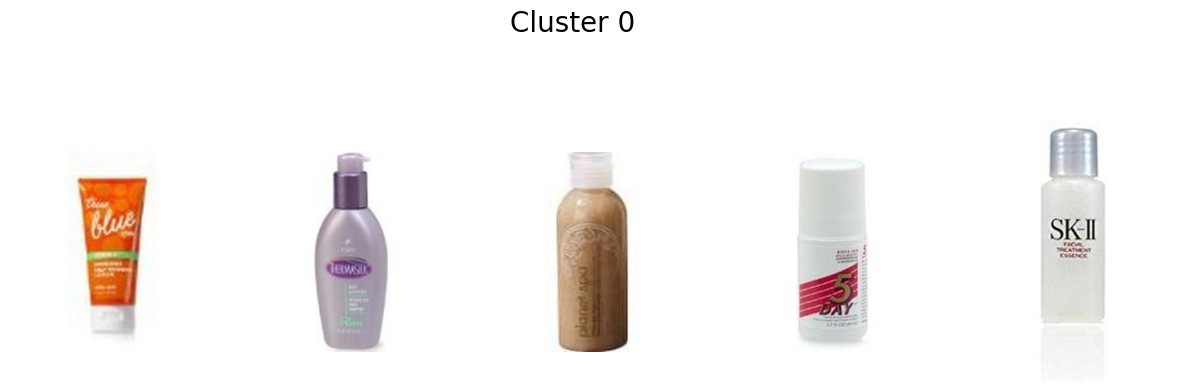

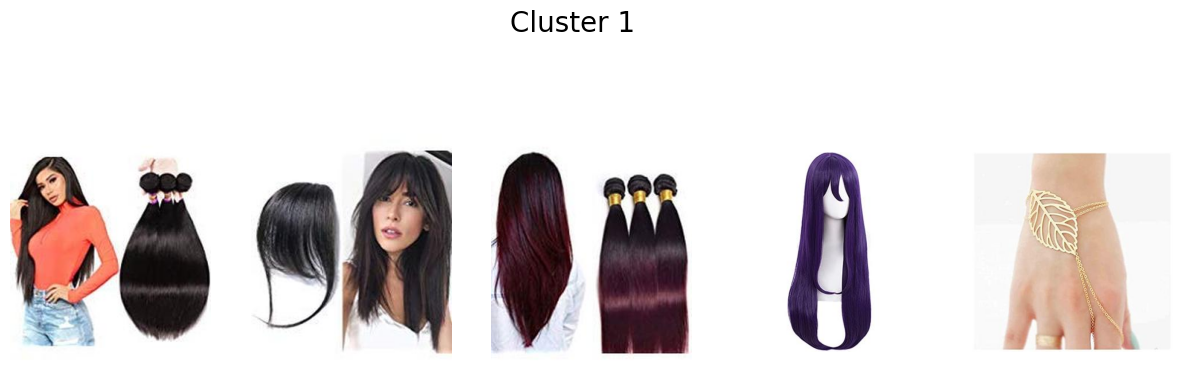

In [164]:
path = "./data/clusters/all_beauty_embeddings"
show_cluster_images(path, cluster_count=4, images_to_show=5)

# 5. Creating Image Classification Model

## 5.1. Splitting the Image Dataset into Train, Validation, and Test Sets

15% of the dataset was allocated for validation and another 15% for testing. The validation set was used during model training, while the test set was reserved for evaluating the model's performance after training was completed.


In [26]:
def copy_images(subset_df: pd.DataFrame, target_dir: str) -> None:
    """
    Copies images from the DataFrame to the specified target directory.

    Parameters:
    - subset_df (pd.DataFrame): A DataFrame containing image paths in the 'path' column.
    - target_dir (str): The target directory where the images will be copied.

    Returns:
    - None: This function does not return any value.
    """
    for _, row in subset_df.iterrows():
        shutil.copy2(row["path"], target_dir)


def split_data_into_train_val_test(
    df_processed: pd.DataFrame, 
    output_dir: str, 
    train_ratio: float = 0.7, 
    random_seed: int = 42 
) -> pd.DataFrame:
    """
    Splits dataset images into train, validation, and test sets based on a fixed train ratio.
    Validation and test sets are equally divided from the remaining data.

    Parameters:
    - df_processed (pd.DataFrame): DataFrame containing 'path' and 'category' columns for images.
    - output_dir (str): Directory where the train/validation/test folders will be created.
    - train_ratio (float): Proportion of data to allocate to the train set.

    Returns:
    - pd.DataFrame: A DataFrame summarizing the counts of images in each set (train/val/test) per category.
    """
    
    np.random.seed(random_seed)
  
    # Shuffle the data
    df_processed = shuffle(df_processed).reset_index(drop=True)
    class_summary = {"Class": [], "Train Count": [], "Validation Count": [], "Test Count": []}
    
    for class_name, class_group in tqdm(df_processed.groupby("category"), desc="Splitting Images.."):
        
        total_images = len(class_group)
        train_count = int(total_images * train_ratio)
        remaining_count = total_images - train_count
        val_count = test_count = remaining_count // 2
        
        class_summary["Class"].append(class_name)
        class_summary["Train Count"].append(train_count)
        class_summary["Validation Count"].append(val_count)
        class_summary["Test Count"].append(test_count)

        train_df = class_group[:train_count]
        val_df = class_group[train_count:train_count + val_count]
        test_df = class_group[train_count + val_count:]
        
        train_dir = os.path.join(output_dir, "train", class_name)
        val_dir = os.path.join(output_dir, "validation", class_name)
        test_dir = os.path.join(output_dir, "test", class_name)
        
        for dir_path in [train_dir, val_dir, test_dir]:
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)
        
        copy_images(train_df, train_dir)
        copy_images(val_df, val_dir)
        copy_images(test_df, test_dir)
    
    summary_df = pd.DataFrame(class_summary)
    
    return summary_df


In [27]:
model_images_output = "./data/modeling/images"
summary_df = split_data_into_train_val_test(df, model_images_output)
summary_df

Splitting Images..: 100%|████████████████████████████████████████████████████████████████████| 3/3 [00:21<00:00,  7.16s/it]


Class  Train Count  Validation Count  Test Count
0                all_beauty        28000              6000        6000
1             digital_music        28000              6000        6000
2  health_and_personal_care        28000              6000        6000

Class  Train Count  Validation Count  Test Count
0                all_beauty         5600               700         700
1             digital_music         5600               700         700
2  health_and_personal_care         5600               700         700


## 5.2. Creating EfficientNet Transfer learning Model

In this study, the **transfer learning** method will be utilized to solve the classification problem.  

Transfer learning is a machine learning technique where a pre-trained model's weights are reused for a new dataset. This method is especially effective for achieving quick and accurate results on large and complex datasets. Pre-trained models leverage features learned from extensive datasets (e.g., ImageNet) to enhance performance and reduce training time on smaller datasets.  

**Model Selection**  
Some popular transfer learning models considered for this study are:  
- **VGG**: A simple architecture but computationally expensive due to a high number of parameters.  
- **ResNet**: Uses residual connections to address the "vanishing gradient" problem, making it successful for very deep architectures.  
- **MobileNet**: A lightweight model suitable for resource-constrained environments.  
- **EfficientNet**: A state-of-the-art model that achieves high accuracy with fewer parameters.  

**Choosing EfficientNet**  
The **EfficientNet** model has been chosen for this study due to the following reasons:  
1. EfficientNet provides a modern architecture that achieves high accuracy with fewer parameters.  
2. It balances speed and accuracy effectively.  
3. With proper hardware support (e.g., GPU usage), it performs well even on large datasets.  

The training process for the EfficientNet model will be detailed in the following sections.


**Key Steps in Model Implementation**

- **Class Definition:**  
  - Created a `CustomEfficientNetClassifier` class based on TensorFlow's `Model` API.
  - Integrated a pre-trained EfficientNetB0 model as the backbone, setting `include_top=False` to exclude the default classification head.
  - Only the final layer of the model has been trained. The others have been freezed.

-  **Input Layer:**  
  - The input shape has been set to `224 x 224`, which is the standard size for image inputs in this deep learning model.

- **Global Average Pooling:**  
  - Applied a `GlobalAveragePooling2D` layer to reduce the spatial dimensions of the feature maps to a vector format.

- **Dropout Layer:**  
  - Added a `Dropout` layer with a rate of 50% to reduce overfitting during training.

- **Output Layer:**  
  - Defined a fully connected `Dense` layer with `softmax` activation to classify the images into `num_classes` categories.

- **Data Augmentation:**  
  - Used `ImageDataGenerator` to apply augmentation techniques like normalization,  rotation, zooming, and flipping for better generalization.

- **Training Loop:**  
  - Designed a `train` method to:
    - Load and preprocess the dataset from directories.
    - Define callbacks like `ModelCheckpoint`, `EarlyStopping`, and `ReduceLROnPlateau` for better model optimization.
    - Compile and train the model using the Adam optimizer and categorical cross-entropy loss.

- **steps_per_epoch and validation_steps:** These parameters control the number of steps the model processes during each epoch for training and validation. They are calculated based on the number of samples in the dataset divided by the batch size to ensure balanced and consistent training.

- **Return Values:**  
  - After training, the method returns the trained model and the training history for further analysis.


In [5]:

@saving.register_keras_serializable()
class CustomEfficientNetClassifier(Model):
    def __init__(self, input_shape=(224, 224, 3), num_classes=3, name="custom_efficientnet", **kwargs):
        super(CustomEfficientNetClassifier, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.input_shape = input_shape

        # Pretrained EfficientNet base model
        base_model = EfficientNetB0(weights="imagenet",  include_top=False, input_shape=self.input_shape)
        
        # Freeze all layers except the last 1
        for layer in base_model.layers[:-1]:
            layer.trainable = False


        self.base_model = base_model
        self.global_avg_pool = GlobalAveragePooling2D()
        self.dropout = Dropout(0.5)
        self.output_layer = Dense(self.num_classes, activation="softmax")

    def call(self, inputs, training=False):
        x = self.base_model(inputs, training=False)
        x = self.global_avg_pool(x)
        x = self.dropout(x, training=training)
        outputs = self.output_layer(x)
        return outputs

    def get_config(self):
        config = super(CustomEfficientNetClassifier, self).get_config()
        config.update({
            "input_shape": self.input_shape,
            "num_classes": self.num_classes
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def train(self, train_dir, val_dir, batch_size=32, epochs=10):
        # Data augmentation for training data
        train_datagen = ImageDataGenerator(
            rescale=1.0/255,
            # rotation_range=30,
            # width_shift_range=0.2,
            # height_shift_range=0.2,
            # shear_range=0.2,
            # zoom_range=0.2,
            # horizontal_flip=True,
            # fill_mode='nearest'
        )

        # Rescaling for validation data
        val_datagen = ImageDataGenerator(rescale=1.0/255)

        # Data generators
        target_size = self.input_shape[:2]
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=target_size,
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=True 
        )

        val_generator = val_datagen.flow_from_directory(
            val_dir,
            target_size=target_size,
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=False 
        )

        # Callbacks
        checkpoint_val_loss = ModelCheckpoint(
            filepath="./model/best_efficientnet_model.keras",
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=False,
            mode="min",
            verbose=1
        )

        early_stopping = EarlyStopping(
            monitor="val_loss",
            patience=6,
            verbose=1
        )

        lr_callback = ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.3,
            patience=4,
            min_lr=1e-5,
            verbose=1
        )
      
        self.compile(
            optimizer=Adam(learning_rate=0.001),
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )

        history = self.fit(
            train_generator,
            validation_data=val_generator,
            epochs=epochs,
            callbacks=[checkpoint_val_loss, early_stopping, lr_callback],
            steps_per_epoch=train_generator.samples // batch_size,
            validation_steps=val_generator.samples // batch_size
        )

        return self, history

In [6]:
train_dir = "./data/modeling/images/train"
val_dir = "./data/modeling/images/validation"
num_classes = 3
input_shape = (224, 224, 3)
epochs = 200
batch_size = 32

model = CustomEfficientNetClassifier(input_shape=input_shape, num_classes=num_classes)
model, history = model.train(train_dir=train_dir, val_dir=val_dir, batch_size=batch_size, epochs=epochs)

I0000 00:00:1734889221.686156    8817 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20926 MB memory:  -> device: 0, name: NVIDIA A10G, pci bus id: 0000:00:1e.0, compute capability: 8.6


Found 84000 images belonging to 3 classes.
Found 18000 images belonging to 3 classes.
Epoch 1/200


I0000 00:00:1734889234.891577    8872 service.cc:148] XLA service 0x7c18c8049920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734889234.891610    8872 service.cc:156]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2024-12-22 17:40:35.128298: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734889236.218914    8872 cuda_dnn.cc:529] Loaded cuDNN version 90501


   6/2625 ━━━━━━━━━━━━━━━━━━━━ 1:21 31ms/step - accuracy: 0.3346 - loss: 1.1251   

I0000 00:00:1734889241.937015    8872 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2624/2625 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3420 - loss: 1.1186  

2024-12-22 17:42:08.173347: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2037', 4 bytes spill stores, 4 bytes spill loads

2024-12-22 17:42:08.355923: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2037', 400 bytes spill stores, 400 bytes spill loads

2024-12-22 17:42:08.489566: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2037', 4176 bytes spill stores, 4048 bytes spill loads




Epoch 1: val_loss improved from inf to 1.12526, saving model to ./model/best_efficientnet_model.keras
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 121s 40ms/step - accuracy: 0.3420 - loss: 1.1186 - val_accuracy: 0.3336 - val_loss: 1.1253 - learning_rate: 0.0010
Epoch 2/200
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3468 - loss: 1.1122  
Epoch 2: val_loss improved from 1.12526 to 1.09792, saving model to ./model/best_efficientnet_model.keras
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 106s 41ms/step - accuracy: 0.3468 - loss: 1.1122 - val_accuracy: 0.3866 - val_loss: 1.0979 - learning_rate: 0.0010
Epoch 3/200
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3543 - loss: 1.1077  
Epoch 3: val_loss improved from 1.09792 to 1.08887, saving model to ./model/best_efficientnet_model.keras
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 96s 37ms/step - accuracy: 0.3543 - loss: 1.1077 - val_accuracy: 0.4066 - val_loss: 1.0889 - learning_rate: 0.0010
Epoch 4/200
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accura

In [7]:
model = load_model("./model/best_efficientnet_model.keras")

In [8]:
model.summary()

Model: "custom_efficientnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,061,102 (15.49 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 7,688 (30.04 KB)

## 5.3. Model  Evaluation

The model achieved 47% accuracy on the test set. Looking at the confusion matrix and classification report, we can see that the classification is poor for each category. The reason for this is the large number of unique images in the categories of All Beauty, Digital Music, and Health and Personal Care, which were downloaded from the internet. When we look at the accuracy and validation loss graphs, we can see that proper training has not been achieved.

In [9]:
def plot_training_history(result: Dict[str, list]) -> None:
    """
    Plots the training and validation loss and accuracy graphs from the model's training history.

    Parameters:
    -----------
    result : Dict[str, list]
        A dictionary containing the history of the model's training and validation metrics. 
        It should include at least the following keys:
        - 'loss': List of training loss values.
        - 'val_loss': List of validation loss values.
        - 'accuracy': List of training accuracy values.
        - 'val_accuracy': List of validation accuracy values.

    Returns:
    --------
    None
        This function does not return any value, it just displays the plots.
    """
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(result.history['loss'], label='Train Loss')
    plt.plot(result.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graph')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(result.history['accuracy'], label='Train Accuracy')
    plt.plot(result.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Graph')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

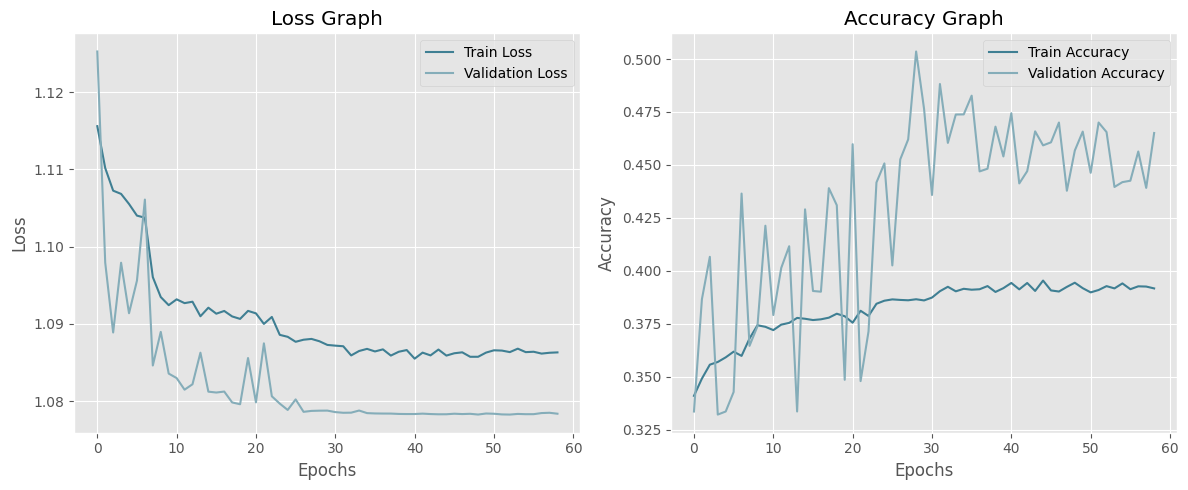

In [10]:
plot_training_history(history)

In [11]:
def evaluate_model(
    model, 
    test_dir: str, 
    target_size: tuple = (224, 224), 
    batch_size: int = 32
) -> None:
    """
    Evaluate the model on the test dataset and display performance metrics.

    Parameters:
    model: The trained model to evaluate.
    test_dir (str): Directory path to the test dataset.
    target_size (tuple): Target size for the input images (height, width).
    batch_size (int): Number of images to process in each batch.

    Returns:
    None: This function prints the accuracy, precision, recall, and displays
          confusion matrix and classification report.
    """

 
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle=False
    )

    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    accuracy = accuracy_score(true_classes, predicted_classes)
    print("Accuracy:", accuracy)

    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    print(classification_report(true_classes, predicted_classes))
    
    return test_generator ,predicted_classes

Found 18000 images belonging to 3 classes.
563/563 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step
Accuracy: 0.4671666666666667


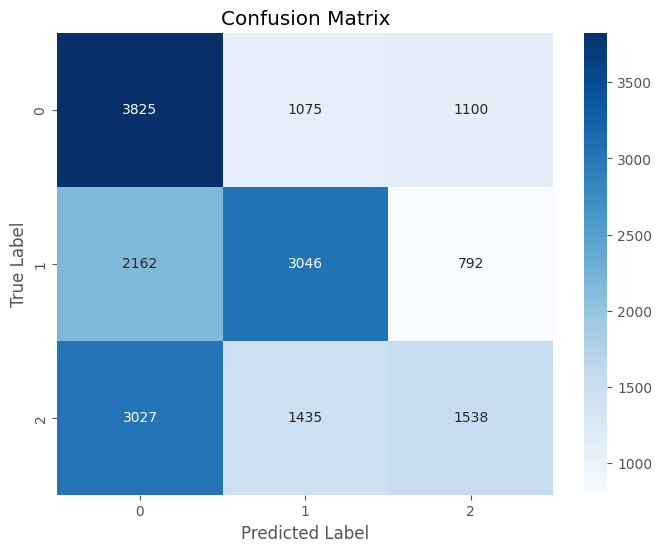

              precision    recall  f1-score   support

           0       0.42      0.64      0.51      6000
           1       0.55      0.51      0.53      6000
           2       0.45      0.26      0.33      6000

    accuracy                           0.47     18000
   macro avg       0.47      0.47      0.45     18000
weighted avg       0.47      0.47      0.45     18000



              precision    recall  f1-score   support

           0       0.40      1.00      0.57        27
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        21

    accuracy                           0.40        68
   macro avg       0.13      0.33      0.19        68
weighted avg       0.16      0.40      0.23        68



In [18]:
test_directory = "./data/modeling/images/test"
test_generator, predicted_classes = evaluate_model(model, test_directory)

### 5.3.1 Analyzing Misclassifications

Out of 18000 test samples, 9591 have been misclassified.

In [13]:
def analyze_and_visualize_misclassifications(test_generator, predicted_classes, num_samples=10) -> None:
    """
    Analyze and visualize misclassified images from the test dataset.

    Parameters:
    test_generator: The generator used to load the test data.
    predicted_classes: The predicted class indices from the model.
    num_samples: The number of misclassified images to display.

    Returns:
    None: This function prints the total number of misclassified images and shows a plot of some misclassified examples.
    """
    
    test_generator.reset()

    df = pd.DataFrame({
        'filename': test_generator.filenames,
        'predict': predicted_classes,  
        'y': test_generator.classes
    })
    misclassified = df[df['y'] != df['predict']]
    total_misclassified = misclassified.shape[0]
    
    print(f'Total misclassified images: {total_misclassified}')
    print("\nMisclassified Images:")
    print(misclassified.head())

    if total_misclassified > 0:
   
        samples_to_display = min(num_samples, total_misclassified)
        misclassified_samples = misclassified.sample(samples_to_display)
        
        cols = 5
        rows = (samples_to_display + cols - 1) // cols 
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
        
        for ax, (_, row) in zip(axes.flatten(), misclassified_samples.iterrows()):
            img_path = test_generator.directory + '/' + row['filename']
            img = plt.imread(img_path)
            ax.imshow(img)
            ax.set_title(f'True: {row["y"]}, Pred: {row["predict"]}')
            ax.axis('off')

        for i in range(samples_to_display, len(axes.flatten())):
            axes.flatten()[i].axis('off')

        plt.tight_layout()
        plt.show()

Total misclassified images: 9591

Misclassified Images:
                       filename  predict  y
38   all_beauty/219txAmQkVL.jpg        1  0
74   all_beauty/21P7hzk01aL.jpg        2  0
91   all_beauty/21aDesLozvL.jpg        1  0
106  all_beauty/21l97FjCBfL.jpg        1  0
115  all_beauty/21oOiLzWhJL.jpg        2  0


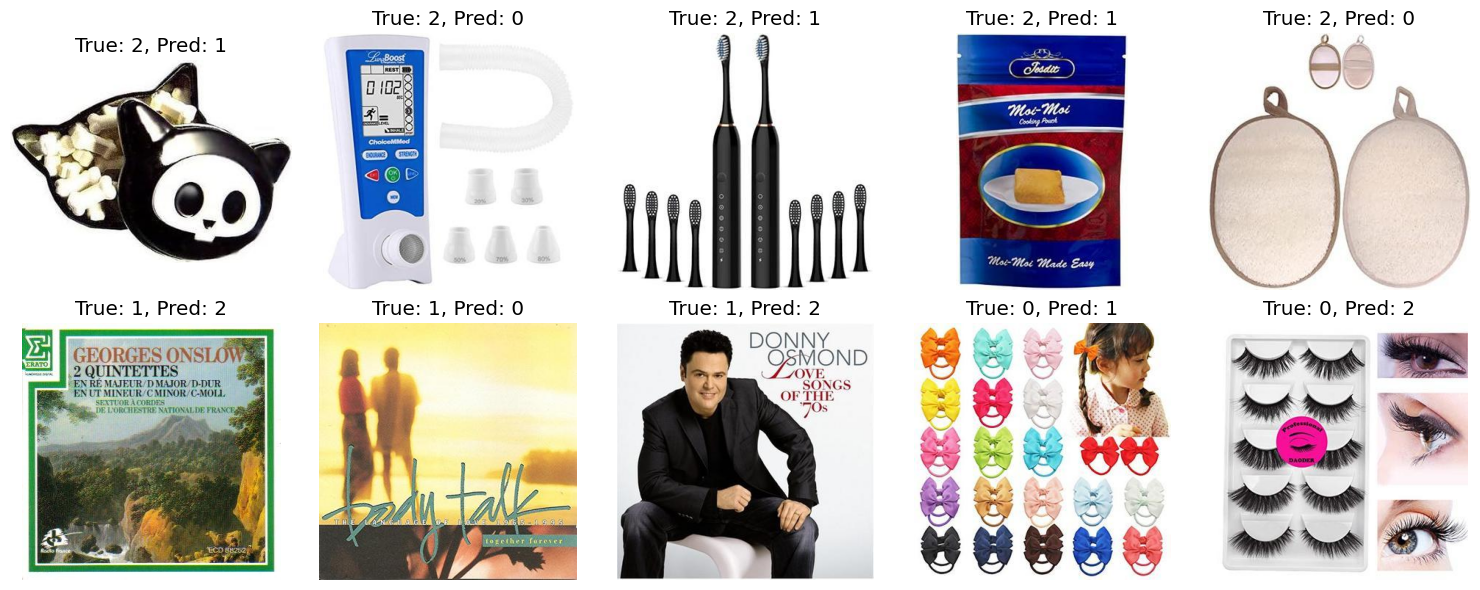

In [14]:
analyze_and_visualize_misclassifications(test_generator, predicted_classes, num_samples=10)

### 5.3.2 Prediction

A random image for each category in the test folder has been selected and compiled into a list and it was observed that the model has correctly classified 2 randomly selected images from each category in the model test image dataset.

In [15]:
def predict_single_image(model, image_path, test_generator):
    """
    Predict the class of a single image using a trained model.

    Parameters:
    model: The trained Keras model for image classification.
    image_path: Path to the image to be classified.
    test_generator: Keras ImageDataGenerator flow generator.

    Returns:
    None: This function displays the image and prints the predicted class with confidence.
    """
    image = load_img(image_path, target_size=(224, 224))
    plt.imshow(image)
    plt.title(f"Selected Image: {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()
   
    image_array = img_to_array(image) / 255.0 
    image_array = np.expand_dims(image_array, axis=0)  

    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions, axis=1)[0] 

    class_indices = test_generator.class_indices
    class_labels = {v: k for k, v in class_indices.items()} 

    predicted_label = class_labels[predicted_index]
    confidence = predictions[0][predicted_index]

    print(f"Predicted Label: {predicted_label} (Confidence: {confidence:.2f})")

In [22]:
test_folder = "./data/modeling/images/test" 
test_df = df_from_image_folders(test_folder)
prediction_list = test_df.groupby("category")["path"].sample(1).to_list()

2024-12-22 19:22:41,907 - INFO - Dataframe has been successfully created.


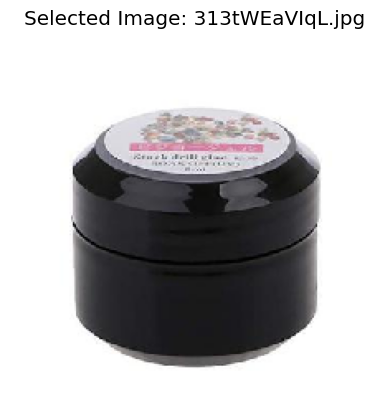

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Label: all_beauty (Confidence: 0.36)
Actual label: all_beauty
                                                  
**************************************************


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Label: digital_music (Confidence: 0.35)
Actual label: digital_music
                                                  
**************************************************


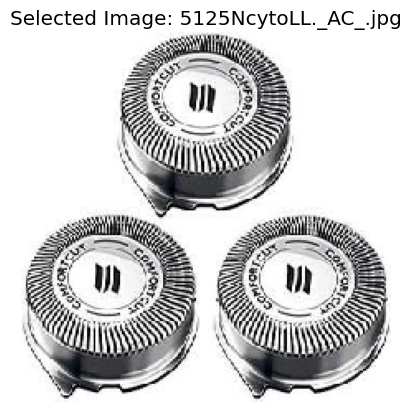

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Label: digital_music (Confidence: 0.43)
Actual label: health_and_personal_care
                                                  
**************************************************


In [23]:
for image in prediction_list:
    category_name = os.path.basename(os.path.dirname(image))
    predict_single_image(model, image, test_generator)
    print(f"Actual label: {category_name}")
    print(50 * " ")
    print(50 * "*")

# 6. Conclusion

In conclusion, the model trained using the EfficientNet-B0 architecture achieved an accuracy of 47% on the test dataset. The model's performance was evaluated using a confusion matrix and classification report, and misclassified images were analyzed to identify areas for improvement. 

This study can be expanded by creating a product-based category structure for the images in each category. By training images specific to these categories, a model can first be built to predict products from product images.